In [151]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Get the vocabulary for the mappings of to and from intergers

words = open("names.txt",'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}


In [121]:
# Build the dataset
X,Y = [],[]
context_length = 3

for w in words:
    context = [0] * context_length
    #print(w)
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [122]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [64]:
C = torch.randn((27,2))
C

tensor([[ 1.4140, -0.9164],
        [ 0.6345, -0.9186],
        [-0.4419,  0.8661],
        [-0.1640, -0.3767],
        [ 0.1695,  0.7452],
        [-2.2785, -0.4671],
        [ 0.1070,  0.6598],
        [-0.5363,  1.1308],
        [ 1.4783,  0.9955],
        [-0.0713,  0.4893],
        [ 0.6374,  0.9106],
        [ 1.3740, -2.3133],
        [ 1.2617, -1.1571],
        [ 1.6125,  0.0337],
        [ 0.1694, -1.0704],
        [ 1.4233,  0.2604],
        [-1.0649, -0.5052],
        [ 0.3267,  0.1601],
        [ 1.0696, -0.2487],
        [ 0.4330, -1.8828],
        [ 0.0865,  0.5502],
        [ 0.4356,  0.5052],
        [ 0.5720,  0.0388],
        [-0.8659, -0.2791],
        [-2.6366,  0.6593],
        [-1.1495, -0.4954],
        [ 0.0128, -0.3272]])

In [67]:
# Create the embeddings
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [82]:
# Create the hidden layer
W1 = torch.randn(6,100)
b1 = torch.randn(100)
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

torch.Size([32, 100])

In [84]:
# Create the output layer
W2 = torch.randn(100,27)
b2 = torch.randn(27)

logits = h @ W2 + b2


In [91]:
counts = logits.exp()
probs = counts / counts.sum(1,keepdim=True)
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(12.2805)

In [123]:
#----- more respectable
X.shape, Y.shape


(torch.Size([228146, 3]), torch.Size([228146]))

In [168]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.rand((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100,27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C , W1, b1, W2, b2]

In [169]:
sum(p.nelement() for p in parameters)

3481

In [170]:
# emb = C[X]
# h = torch.tanh(emb.view(-1,6) @ W1 + b1)
# logits = h @ W2 + b2 
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [171]:
for p in parameters:
    p.requires_grad = True


In [172]:
# Let's expore the best learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [173]:
batch_size = 32
lri = []
lossi = []
for i in range(1000):
    # forward pass
    batch_size = 32
    ix = torch.randint(0, X.shape[0], (batch_size, )) # take 32 random rows
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 
    counts = logits.exp()
    loss = F.cross_entropy(logits, Y[ix])
    print(f"loss: {loss.item()}")
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track states 
    lri.append(lre[i])
    lossi.append(loss.item())
print(f"Batch Loss: {loss}")

loss: 18.216718673706055
loss: 17.264392852783203
loss: 19.162519454956055
loss: 18.43761444091797
loss: 18.856121063232422
loss: 18.14969253540039
loss: 18.646963119506836
loss: 21.12109375
loss: 16.629371643066406
loss: 18.936115264892578
loss: 18.906696319580078
loss: 18.642969131469727
loss: 19.320892333984375
loss: 20.430280685424805
loss: 19.70268440246582
loss: 16.983797073364258
loss: 15.572093963623047
loss: 16.06012535095215
loss: 17.156600952148438
loss: 20.521595001220703
loss: 17.584232330322266
loss: 15.95713996887207
loss: 19.053668975830078
loss: 17.390226364135742
loss: 20.290674209594727
loss: 17.420637130737305
loss: 17.96617317199707
loss: 18.25296974182129
loss: 20.724184036254883
loss: 19.874507904052734
loss: 18.77593231201172
loss: 15.199437141418457
loss: 18.844594955444336
loss: 16.15625
loss: 16.44187355041504
loss: 17.25429916381836
loss: 18.146106719970703
loss: 15.956239700317383
loss: 13.610613822937012
loss: 18.907594680786133
loss: 17.94695281982422
los

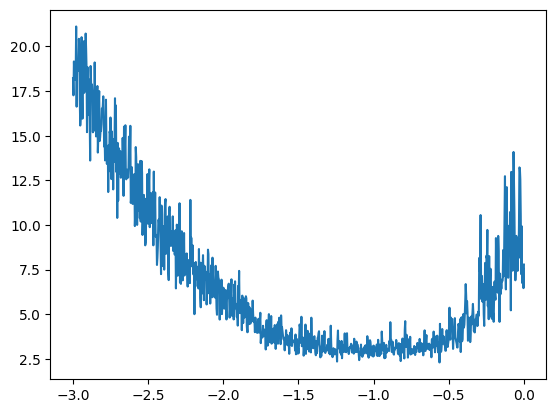

In [174]:
plt.plot(lri,lossi)

In [141]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2 
counts = logits.exp()
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(4.1058, grad_fn=<NllLossBackward0>)


1. We need to determine the proper learning rate using the above code.
   From the above plot, it looks like the exponent of the learning rate should be -1.0, or 0.1
2. Train for 10-20k steps
3. Once we've trained, do a learning rate decay, say by a factor of 10. So 0.1 -> 0.01